In [1]:
# set up the environment
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [2]:
df = pd.read_csv("../data/phages_per_genome.tsv.gz", delimiter='\t', compression='gzip')
df.head()

,Contig,Genome length,Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1_ASM313v1_genomic.gbff.gz,2396359,10,16.0,2.0,1.0,13.0,48916.0
1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,5269725,1,31.0,1.0,10.0,20.0,40297.0
2,GCA_000003925.1_ASM392v1_genomic.gbff.gz,5561906,1,38.0,6.0,13.0,19.0,268081.0
3,GCA_000003955.1_ASM395v1_genomic.gbff.gz,5790501,1,46.0,6.0,11.0,29.0,166286.0
4,GCA_000005825.2_ASM582v2_genomic.gbff.gz,4249248,3,33.0,3.0,9.0,21.0,93416.0


In [3]:
df = df.replace([np.nan], 0)

In [4]:
df['fraction pp'] = df['bp prophage']/df['Genome length']

## Compare genome length and prophage bp

Use statistics!

In [5]:
exog = sm.add_constant(df["Genome length"])
model = sm.OLS(df["bp prophage"], exog).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            bp prophage   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     5683.
Date:                Mon, 08 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:00:26   Log-Likelihood:            -1.1422e+05
No. Observations:                9001   AIC:                         2.284e+05
Df Residuals:                    8999   BIC:                         2.285e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.193e+04   2201.254    -14.505      0.000   -3.62e+04   -2.76e+04
Genome length     0.0378      0.001     75.389      0.000       0.037       0.039
==============================================================================
Omnibus:                     1505.603   Durbin-Watson:                   1.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5112.754
Skew:                           0.836   Prob(JB):                         0.00
Kurtosis:                       6.292   Cond. No.                     1.17e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
print(f"The equation is {model.params['Genome length']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for genome length is {model.pvalues['Genome length']:.3f}")

The equation is 0.038x + -31929.296
The R-squared is 0.387
The p-value for genome length is 0.000


In [7]:
df['bp pp fit'] = (model.params['Genome length'] * df['Genome length']) + model.params['const']

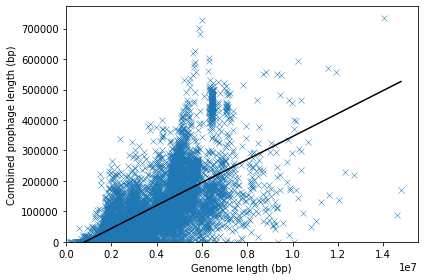

In [36]:
ax = sns.scatterplot(x='Genome length', y='bp prophage', data=df, marker='x')
sns.lineplot(x='Genome length', y='bp pp fit', data=df, color='k')
ax.set_ylabel('Combined prophage length (bp)')
ax.set_xlabel('Genome length (bp)')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/lengths.png')

## Compare number of prophages and genome length

In [9]:
exog = sm.add_constant(df["Genome length"])
keptmodel = sm.OLS(df["Kept"], exog).fit()
keptmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Kept   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     4555.
Date:                Mon, 08 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:00:27   Log-Likelihood:                -23370.
No. Observations:                9001   AIC:                         4.674e+04
Df Residuals:                    8999   BIC:                         4.676e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.9707      0.091    -10.665      0.000      -1.149      -0.792
Genome length  1.398e-06   2.07e-08     67.491      0.000    1.36e-06    1.44e-06
==============================================================================
Omnibus:                     2051.771   Durbin-Watson:                   1.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9038.690
Skew:                           1.051   Prob(JB):                         0.00
Kurtosis:                       7.437   Cond. No.                     1.17e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
print(f"The equation is {keptmodel.params['Genome length']}x + {keptmodel.params['const']:.3f}")
print(f"The R-squared is {keptmodel.rsquared:.3f}")
print(f"The p-value for genome length is {keptmodel.pvalues['Genome length']:.3f}")

The equation is 1.3982759145919112e-06x + -0.971
The R-squared is 0.336
The p-value for genome length is 0.000


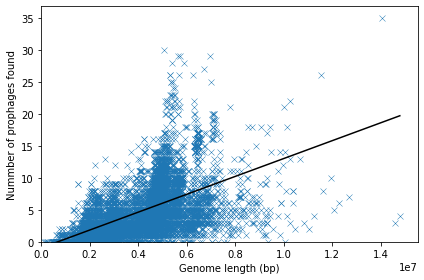

In [37]:
df['kept fit'] = (keptmodel.params['Genome length'] * df['Genome length']) + keptmodel.params['const']
ax = sns.scatterplot(x='Genome length', y='Kept', data=df, marker='x')
sns.lineplot(x='Genome length', y='kept fit', data=df, color='k')
ax.set_ylabel('Nummber of prophages found')
ax.set_xlabel('Genome length (bp)')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/num_kept.png')

## Compare number of prophages and total prophage bp

This bloody ought to be +ve!

The equation is 23135.343x + 12609.905
The R-squared is 0.845
The p-value for number of phages kept is 0.000


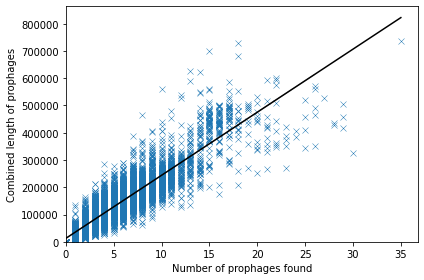

In [38]:
exog = sm.add_constant(df["Kept"])
keptvlen = sm.OLS(df["bp prophage"], exog).fit()
print(f"The equation is {keptvlen.params['Kept']:.3f}x + {keptvlen.params['const']:.3f}")
print(f"The R-squared is {keptvlen.rsquared:.3f}")
print(f"The p-value for number of phages kept is {keptvlen.pvalues['Kept']:.3f}")
df['kept vs bp fit'] = (keptvlen.params['Kept'] * df['Kept']) + keptvlen.params['const']
ax = sns.scatterplot(x='Kept', y='bp prophage', data=df, marker='x')
sns.lineplot(x='Kept', y='kept vs bp fit', data=df, color='k')
ax.set_ylabel('Combined length of prophages')
ax.set_xlabel('Number of prophages found')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/keptpplen.png')

### Is there a relationship between # contigs and # phages?

This could be a relationship, especially as a genome gets fragmented.

In [41]:
exog = sm.add_constant(df["Contigs"])
model = sm.OLS(df["Total Predicted Prophages"], exog).fit()
print("\nFor TOTAL prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
df['contigs vs total pp'] = (model.params['Contigs'] * df['Contigs']) + model.params['const']

exog = sm.add_constant(df["Contigs"])
model = sm.OLS(df["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
df['contigs vs kept pp'] = (model.params['Contigs'] * df['Contigs']) + model.params['const']


For TOTAL prophages
The equation is 0.192x + 25.894
The R-squared is 0.198
The p-value for number of phages kept is 0.000

For KEPT prophages
The equation is 0.004x + 4.528
The R-squared is 0.003
The p-value for number of phages kept is 0.000


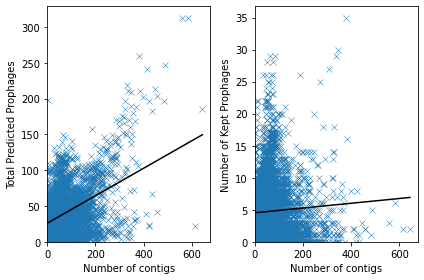

In [42]:
fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=df, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=df, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=df, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=df, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/contigspp.png')

## Some general data about the prophages

In [13]:
print(f"There are {df['Kept'].mean():.2f} prophages per genome on average, with a mean combined length of {df['bp prophage'].mean():,.0f} bp, so {df['bp prophage'].mean()/df['Kept'].mean():,.0f} bp per prophage")

There are 4.72 prophages per genome on average, with a mean combined length of 121,848 bp, so 25,806 bp per prophage


In [14]:
print(f"The most prophages is {max(df['Kept'])} in {df.loc[df['Kept'].argmax()]['Contig']}")
print(f"The longest combined amount of prophage DNA is {max(df['bp prophage'])} in {df.loc[df['bp prophage'].argmax()]['Contig']}")
print(f"The highest fraction of prophage DNA is {max(df['fraction pp']) * 100:.3f}% in {df.loc[df['fraction pp'].argmax()]['Contig']}")

The most prophages is 35.0 in GCA_009725235.1_ASM972523v1_genomic.gbff.gz
The longest combined amount of prophage DNA is 735047.0 in GCA_009725235.1_ASM972523v1_genomic.gbff.gz
The highest fraction of prophage DNA is 14.630% in GCA_000008685.2_ASM868v2_genomic.gbff.gz


Text(0.5, 0, 'Number of prophages identified')

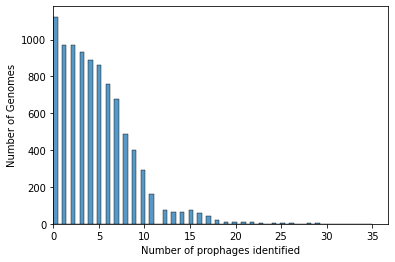

In [25]:
ax = sns.histplot(df['Kept'])
ax.set_xlim(0,)
ax.set_ylabel("Number of Genomes")
ax.set_xlabel("Number of prophages identified")